In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from  scipy.stats import norm
from  scipy.stats import binom
from scipy.stats import beta
from  scipy.stats import uniform
from scipy.stats import gaussian_kde

import pystan
from pystan.constants import MAX_UINT

%run ../tools.py

ERROR:root:File `'../tools.py'` not found.


# Exercise A

The goal of this exercise is to implement the Metropolis-Hastings method as seen in Lesson 5. Consider a variable y_i representing the number of success of an experiment i repeated n times. Now consider a vector Y containing the number of success of N independent experiments y_i. We assume that each experiment_i share a common probability of success $\theta = 0.3$. Therefore we can generate the following data:

In [2]:
N = 100
n = 100
theta = 0.3

Y = binom.rvs(n, theta, size=N)
    
print(Y[:10])

[24 31 28 43 32 24 32 25 34 30]


**1) We will assume a prior Beta distribution with parameters a=0.5 and b=0.5 for $\theta$. Write the data likelihood p(Y|$\theta$) and the posterior distribution p($\theta$ | Y).**

**2) Estimate the posterior distirbution p($\theta$|Y) using the Metropolis-Hastings algorithm.**

In [3]:
def proposal(prop_mu, prop_sigma):
    return scipy.stats.norm.rvs(loc = prop_mu, scale = prop_sigma, size = 1)

def log_likelihood(param):
    return np.sum([binom.logpmf(y_i,n,param) for y_i in Y])

def log_prior(param):
    return beta.logpdf(param, 0.5, 0.5)

def log_posterior(param):
    return log_likelihood(param) + log_prior(param)

**3) Plot the posterior probability density functions obtained with the MCMC approximation and the analytical solution.**

# Exercise B

This year a farmer ran an experiment  where he gave 10 cows medicine A and 10 medicine B and then measured whether they got sick (0) or not (1) during the summer season. Here is the resulting data:

In [10]:
cowA = np.array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])
cowB = np.array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0])

**1) The farmer wants to know: How effective are the drugs? What is the evidence that medicine A is better or worse than medicine B ?**

The outcome for each cow taking medecine A can be modeled as a random variable following a Bernouilli distribution with parameter $\theta_1$. Similarly, the outcome for each cow taking medecine B can be modeled as a random variable following a Bernouilli distribution with parameter $\theta_2$. Let's assume a unifrom prior for both $\theta_1$ and $\theta_2$. Our goal here is to obtain a posterior distribution of these two parameters. In this exercise, we propose to do it through the HMC method using the Pystan package.

**2)** Earlier this year the farmer  ran an experiment where he gave 10 cows a special diet that could increase the milk production. He recorded the number of liters of milk from these “diet” cows and from 15 “normal” cows during one month. This is the data:

In [14]:
diet_milk = np.array([651., 679., 374., 601., 401., 609., 767., 709., 704., 679.])
normal_milk = np.array([798., 1139., 529., 609., 553., 743., 151., 544., 488., 555., 257., 692., 678., 675., 538.])

**2a)** The farmer now wants to know: Was the diet any good, does it results in better milk production? 

The most common approach here would be to model the milk production of each cow as a normal distribution. For the cows following a diet, their milk production can be modeled as $y_i \sim \mathcal{N}(\mu_{diet}, \sigma^{2}_{diet})$, while for normal cows the milk production can be modeled as $y_i \sim \mathcal{N}(\mu_{normal}, \sigma^{2}_{normal})$.
We should also add priors for these four parameters. A lazy option here could be to assign them uniform priors.

**3)** The farmer also has chickens. He tries different diets on them too with the hope that they will produce more eggs. Below is the number of eggs produced in one week by chickens on a diet and chickens eating normal chicken food:

In [19]:
diet_eggs = np.array([6, 4, 2, 3, 4, 3, 0, 4, 0, 6, 3])
normal_eggs =  np.array([4, 2, 1, 1, 2, 1, 2, 1, 3, 2, 1])

**3a)** The farmer now wants to know: Was the diet any good, does it result in the chickens producing more eggs ? 

In this case we want to model count data, therefore a reasonable choice to model the number of eggs produced by the chickens would be a Poisson distribution. This distribution has one parameter $\lambda$ which stands for the mean count. 

**4)** The farmer is now wondering whether the amount of time a cow spends outside in the sunshine affects how much milk she produces. To test this he makes a controlled experiment where he picks out 20 cows and assigns to each of them a number of hours she should spend outside each day. The experiment runs for a month and the farmer records the number of liters of milk each cow produces. The data is the following:

In [25]:
milk = np.array([685, 691, 476, 1151, 879, 725, 1190, 1107, 809, 539, 298, 805, 820, 498, 1026, 1217, 1177, 684, 1061, 834])

hours = np.array([3, 7, 6, 10, 6, 5, 10, 11, 9, 3, 6, 6, 3, 5, 8, 11, 12, 9, 5, 5])


**4a)**  Using this data on hours of sunshine and resulting liters of milk the farmer wants to know: Does sunshine affect milk production positively or negatively?


# On informative and uninformative priors

Weakly informative priors are especially critical when inferences are hindered with only weakly identifiable likelihoods, such as those arising from models with sparse data.

To that end, let’s say that we are analyzing a small company and we want to model how much daily rainfall, x, affects daily income, y, using only a few measurements. For this study we will simulate data assuming that the company typically makes a few thousand dollars, or kilodollars (k$), per day without any rain and that a heavy rainfall of a few centimeters per day can severely curtail income.

In [35]:
alpha = 1    # k$
beta = -0.25 # k$ / cm
sigma = 1    # k$

N = 3
rain = 2.*np.random.rand(N) # cm
daily_income = np.random.normal(loc=beta * rain + alpha, scale=sigma) # k$

print(rain)
print(daily_income)

[1.55230128 0.75657204 1.47413516]
[0.79222534 0.0275566  1.75908521]


Assuming that the typical values of both rainfall and income are sufficiently large, we can ignore the fact that they are positive quantities and model their relationship with a linear regression. We can then fit this linear regression in Stan using a very long Markov chain to ensure precise quantification of our posterior distribution.

**1) Fit a linear regression model using Stan and study the posterior distribution of your parameters. You will use a flat prior (this is done automatically by Stan if you don't specify any prior on your parameters.)** 

In [36]:
model_code = """

data {
  int<lower=1> N;
  vector[N] x; // Rainfall in cm
  vector[N] y; // Income in k$
}

parameters {
  real alpha;          // k$
  real beta;           // k$ / cm
  real<lower=0> sigma; // k$
}

model {
  y ~ normal(beta * x + alpha, sigma);
}
"""

stan_model = pystan.StanModel(model_code = model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad303b2e7265050ab0bfc5b7b015fbdc NOW.


In [37]:
data_to_model = dict(N = N, y = daily_income, x = rain)

seed = np.random.randint(0, MAX_UINT, size=1)[0]

fit = stan_model.sampling(data = data_to_model, seed=seed, iter=11000, warmup=1000, chains=1)

fit

Inference for Stan model: anon_model_ad303b2e7265050ab0bfc5b7b015fbdc.
1 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  9.2e7   8.4e7  5.1e8 -9.1e8 -1.6e7  9.7e5  8.3e7  1.6e9     37    1.0
beta  -7.4e7   6.6e7  3.8e8 -1.2e9 -6.4e7 -7.2e5  1.1e7  6.1e8     32   1.01
sigma  2.9e8   5.3e7  7.5e8  3.5e5  4.2e6  3.7e7  2.5e8  2.2e9    197   1.01
lp__  -35.47    0.62    5.0 -43.61 -39.63 -35.81 -31.42 -26.31     65   1.02

Samples were drawn using NUTS at Wed Dec  2 16:50:41 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Unfortunately, the resulting posterior distribution is extremely diffuse and places significant probability on extreme parameter values. The intercept and slope are particularly bad, with the Markov chain meandering far past the positive values that we had assumed.

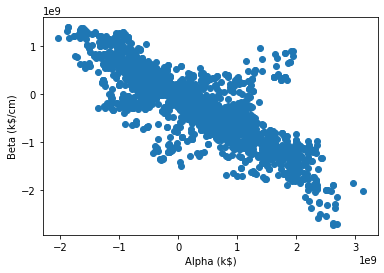

In [38]:
est_alpha = fit.extract()['alpha']
est_beta = fit.extract()['beta']

plt.scatter(est_alpha, est_beta)
plt.xlabel('Alpha (k$)')
plt.ylabel('Beta (k$/cm)')
plt.show()

In hindsight this awkward fit isn’t unexpected. The few data points only weakly inform the posterior which is then dominated by the flat priors. This flat prior basically says that all the points on the real line share a common probability. Therefore, such a prior can pull the posterior towards extreme values that can bias our inferences.

## Flat priors can be informative 

To see this, consider a flat prior for the intercept, $\alpha$, and the question of how much prior probability mass is in the interval −1≤$\alpha$≤1. Because we can’t normalize the prior there is no well-defined answer, but we can at least consider the mass inside the interval relative to the mass outside of the interval, which is, well, infinite! In other words, there is infinitely more prior mass that pulls inferences outside of the interval −1≤α≤1 than prior mass pulling inferences into the interval.

This logic, however, is exactly the same for the the interval −10≤$\alpha$≤10, the interval −100≤$\alpha$≤100, and in fact any finite interval. The flat prior favors the exterior of the any finite interval, pulling the posterior and any resulting inferences towards extreme values.

Although it is tempting to blame this pathological behavior on the fact that flat priors are not well-defined probability distributions and hence cannot be normalized, the behavior is not unique to flat priors. This bias towards extreme values is characteristic of any prior that is extremely diffuse and places significant probability mass at large values. In practice, priors such as $\alpha$∼U(−1000,1000) and $\alpha$∼N(0,1000) can bias our inferences just as strongly as a flat prior.

The real issue is that these diffuse priors are incoherent with our actual prior beliefs. For example, basic physical and economic constraints limit the reasonable values of our parameters, and the linear model isn’t even valid for negative parameter values! Diffuse priors pull the posterior towards these extreme values, conflicting with even the most basic prior information.

Ultimately the misconception about diffuse priors being non-informative comes from reasoning about priors relative to the likelihood. Because diffuse priors distribute probability across such a large region of parameter space, likelihoods that identify much smaller regions of parameter space quickly overwhelm the prior distribution and dominate the posterior distribution. Hence diffuse priors supposedly “let the data speak for themselves”. This will be typically true when dealing with a large amount of data, which is not our case here. 

The more expensive and sparse the data and the more complex the likelihood, the more informative diffuse priors will be. If we want to make reasonable inferences in these models then we need more principled prior distributions that are actually coherent with our prior beliefs.

## Weakly Informative Priors

Weakly informative priors introduce scale information to regularize inferences. Scales are straightforward to reason about in applied problems, especially when units are carefully laid out, and they provide just enough information to regularize non-identified or weakly-identified likelihoods without strongly biasing the posterior away from reasonable parameter values. In order to construct weakly informative priors we need to first decompose our model into components, define default values, identify scales, then choose an explicit shape for our prior.

We cannot define scales, let alone reason about them, until we first decompose our model into interpretable components. In other words, we need to find a parameterization of our model where the parameters are particularly meaningful. The parameterization we have used in our linear regression, for example, is ideal as the intercept, slope, and measurement variability have intuitive interpretations: the intercept, $\alpha$, determines the base income without any rainfall, the slope, $\beta$, controls how a change in rainfall affects income, and the measurement variation, $\sigma$, quantifies the natural variability of daily income.

## Weakly Informative Priors Under Well-Chosen Scales

### Light-Tailed Weakly Informative Priors

When the scales are well-chosen all weakly informative priors behave similarly, regularizing the posterior by penalizing extreme parameter values. The exact shape of a weakly informative prior, however, does introduce some important differences in how strong that regularization is. Let’s first consider a relatively light-tailed weakly informative prior that utilizes Gaussian distributions. Because we simulated the data already in natural units, the weakly informative priors are given simply by unit-scale Gaussians.

**2) Fit a linear regression model using Stan. You will use a standard Gaussian as prior for all the parameters.** 

In [39]:
model_code = """

data {
  int<lower=1> N;
  vector[N] x; // Rainfall in cm
  vector[N] y; // Income in k$
}

parameters {
  real alpha;          // k$
  real beta;           // k$ / cm
  real<lower=0> sigma; // k$
}

model {

  alpha ~ normal(0, 1);
  beta ~ normal(0, 1);
  sigma ~ normal(0, 1);
  y ~ normal(beta * x + alpha, sigma);
  
}
"""

stan_model = pystan.StanModel(model_code = model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b320ac17a5627723500dccc75707fbf4 NOW.


In [40]:
data_to_model = dict(N = N, y = daily_income, x = rain)

seed = np.random.randint(0, MAX_UINT, size=1)[0]

fit = stan_model.sampling(data = data_to_model, seed=seed, iter=11000, warmup=1000, chains=1)

fit

Inference for Stan model: anon_model_b320ac17a5627723500dccc75707fbf4.
1 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.02    0.01   0.73  -1.37  -0.48-4.0e-3    0.5   1.48   3433    1.0
beta    0.64    0.01    0.6  -0.61   0.24   0.66   1.05   1.76   3362    1.0
sigma   0.89  6.8e-3   0.41   0.35   0.59    0.8    1.1   1.89   3596    1.0
lp__   -2.19    0.02   1.27  -5.46  -2.78  -1.87  -1.24  -0.72   3181    1.0

Samples were drawn using NUTS at Wed Dec  2 16:53:23 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

**3) Plot the histogram for the posterior distribution of the parameters. Compare with the ground truth. What do you observe compared to question 1) ? **

Text(0.5, 1.0, 'Posterior sigma')

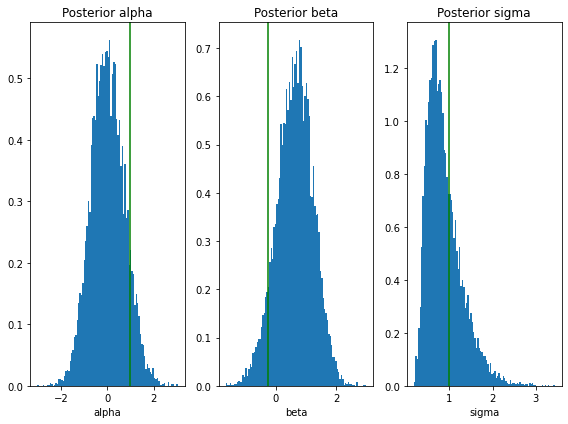

In [41]:
est_alpha = fit.extract()['alpha']
est_beta = fit.extract()['beta']
est_sigma = fit.extract()['sigma']

fig, axes = plt.subplots(1, 3,  tight_layout=True, figsize=(8,6))

axes[0].hist(est_alpha, density=True, bins=100)
axes[0].axvline(alpha, color='green')
axes[0].set_xlabel('alpha')
axes[0].set_title('Posterior alpha')


axes[1].hist(est_beta, density=True, bins=100)
axes[1].axvline(beta, color='green')
axes[1].set_xlabel('beta')
axes[1].set_title('Posterior beta')

axes[2].hist(est_sigma, density=True, bins=100)
axes[2].axvline(sigma, color='green')
axes[2].set_xlabel('sigma')
axes[2].set_title('Posterior sigma')

We now have no problem fitting the model, and the now-regularized posterior accurately captures the parameters that we used to simulate the data. Given that we simulated so little data, the posterior is strongly affected by the weakly informative priors. Because these priors were chosen to be coherent with our prior information, however, even a prior-dominated posterior yields reasonable inferences!

### Heavy-Tailed Weakly Informative Priors

To contrast, let’s now consider the more heavily-tailed priors given by Cauchy distributions. Once again our prescient choice of units admits unit-scale distributions.

**4) Fit a linear regression model using Stan. You will use a standard Cauchy as prior for all the parameters.** 

In [95]:
model_code = """

data {
  int<lower=1> N;
  vector[N] x; // Rainfall in cm
  vector[N] y; // Income in k$
}

parameters {
  real alpha;          // k$
  real beta;           // k$ / cm
  real<lower=0> sigma; // k$
}

model {

  alpha ~ cauchy(0, 1);
  beta ~ cauchy(0, 1);
  sigma ~ cauchy(0, 1);
  y ~ normal(beta * x + alpha, sigma);
  
}
"""

stan_model = pystan.StanModel(model_code = model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_463fd6708e15c5454f5f0e8f9e2cf796 NOW.


In [96]:
data_to_model = dict(N = N, y = daily_income, x = rain)

seed = np.random.randint(0, MAX_UINT, size=1)[0]

fit = stan_model.sampling(data = data_to_model, seed=seed, iter=11000, warmup=1000, chains=1)

fit

Inference for Stan model: anon_model_463fd6708e15c5454f5f0e8f9e2cf796.
1 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.48    0.01   0.84  -1.12  -0.04   0.45   0.97   2.26   3887    1.0
beta    0.26    0.01    0.7  -1.13  -0.14   0.25   0.67   1.72   4193    1.0
sigma   1.39  9.0e-3   0.56   0.71   1.01   1.26   1.61   2.82   3816    1.0
lp__   -5.51    0.03   1.47  -9.23  -6.14  -5.12  -4.43  -3.85   2688    1.0

Samples were drawn using NUTS at Mon Nov 18 14:19:18 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

**5) Plot the histogram for the posterior distribution of the parameters. Compare with the ground truth. What do you observe compared to question 3) ? **

Text(0.5, 1.0, 'Posterior sigma')

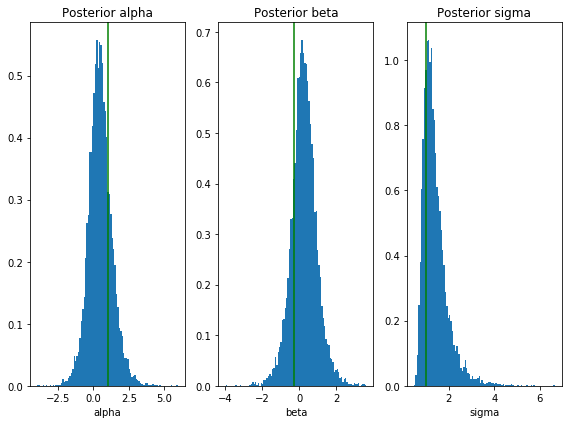

In [97]:
est_alpha = fit.extract()['alpha']
est_beta = fit.extract()['beta']
est_sigma = fit.extract()['sigma']

fig, axes = plt.subplots(1, 3,  tight_layout=True, figsize=(8,6))

axes[0].hist(est_alpha, density=True, bins=100)
axes[0].axvline(alpha, color='green')
axes[0].set_xlabel('alpha')
axes[0].set_title('Posterior alpha')


axes[1].hist(est_beta, density=True, bins=100)
axes[1].axvline(beta, color='green')
axes[1].set_xlabel('beta')
axes[1].set_title('Posterior beta')

axes[2].hist(est_sigma, density=True, bins=100)
axes[2].axvline(sigma, color='green')
axes[2].set_xlabel('sigma')
axes[2].set_title('Posterior sigma')

Once again the weakly informative prior adequately regularizes our inferences. Relative to the Gaussian prior, however, the Cauchy prior places a nontrivial amount of posterior mass into the tails, far above the given scale (as shown in the plot below).

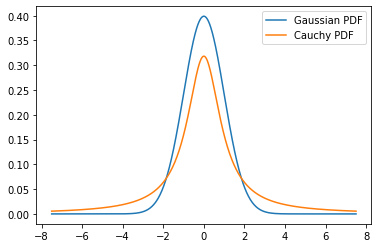

In [66]:
from scipy import stats

xs = np.linspace(-7.5,7.5, 1000)

plt.plot(xs, stats.norm.pdf(xs, loc=0, scale=1), label='Gaussian PDF')
plt.plot(xs, stats.cauchy.pdf(xs, loc=0, scale=1), label='Cauchy PDF')
plt.legend()
plt.show()


This weaker regularization can seriously impact computational performance, especially in models that utilize special functions that become difficult or impossible to compute for extreme inputs, such as ODE solvers or Gaussian process densities. Although the Cauchy prior forces most of the posterior within the specified scale, the heavy tail allows for the occasional extreme value that stresses the evaluation of the special functions and can drastically hinder computational performance. Consequently, heavy-tailed weakly informative priors must be employed with care in practice.

## Weakly Informative Priors Under Poorly-Chosen Scales

The differing behavior of weakly informative priors with different shapes becomes particularly striking when the scales are poorly-chosen, and the likelihood strongly favors parameter values that conflict with the priors.

To demonstrate this difference, let’s simulate a larger data set where the true intercept is above the scale of our chosen units. How this tension between the weakly informative prior and the likelihood manifests in the posterior is extremely sensitive to the exact shape of the weakly informative prior.

In [42]:
alpha = 10   # k$
beta = -0.25 # k$ / cm
sigma = 1    # k$

N = 10
rain = 2.*np.random.rand(N) # cm
daily_income = np.random.normal(loc=beta * rain + alpha, scale=sigma) # k$

print(rain)
print(daily_income)

[1.1605264  0.13021914 1.26012759 1.63414802 0.04128229 1.26428529
 0.67339709 0.07047529 0.98847971 0.24207753]
[13.56761494 10.19730039  9.85481219  8.54227936  8.89469739  9.52990021
  8.40671022 11.27053612  9.86723989  9.83926914]


### The Failure Mode of Light Tails

Let’s first consider the relatively light tail of a Gaussian prior distribution.

**6) Fit a linear regression model using Stan. You will use a standard Gaussian as prior for all the parameters.** 

In [43]:
model_code = """

data {
  int<lower=1> N;
  vector[N] x; // Rainfall in cm
  vector[N] y; // Income in k$
}

parameters {
  real alpha;          // k$
  real beta;           // k$ / cm
  real<lower=0> sigma; // k$
}

model {

  alpha ~ normal(0, 1);
  beta ~ normal(0, 1);
  sigma ~ normal(0, 1);
  y ~ normal(beta * x + alpha, sigma);
  
}
"""

stan_model = pystan.StanModel(model_code = model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b320ac17a5627723500dccc75707fbf4 NOW.


In [44]:
data_to_model = dict(N = N, y = daily_income, x = rain)

seed = np.random.randint(0, MAX_UINT, size=1)[0]

fit = stan_model.sampling(data = data_to_model, seed=seed, iter=11000, warmup=1000, chains=1)

fit

Inference for Stan model: anon_model_b320ac17a5627723500dccc75707fbf4.
1 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.88    0.01   1.03   1.85   3.19   3.89   4.58   5.87   5129    1.0
beta     2.2    0.01   0.84   0.49   1.64   2.21   2.76   3.83   5995    1.0
sigma   3.44  9.0e-3   0.61   2.32   3.01   3.42   3.84   4.69   4583    1.0
lp__  -38.46    0.02   1.23 -41.66 -38.97 -38.15 -37.57 -37.08   4227    1.0

Samples were drawn using NUTS at Wed Dec  2 16:55:50 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

**7) Plot the histogram for the posterior distribution of the parameters. Compare with the ground truth. What do you observe compared to question 3) ? **

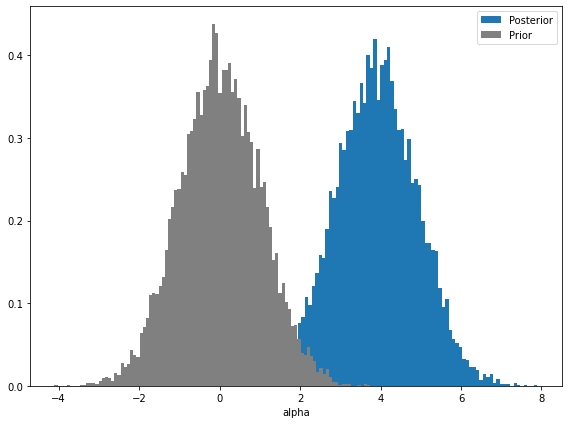

In [46]:
from scipy import stats

est_alpha = fit.extract()['alpha']

prior_hist_alpha = stats.norm.rvs(loc=0., scale=1., size=10000)

fig, ax = plt.subplots(1, 1,  tight_layout=True, figsize=(8,6))

ax.hist(est_alpha, density=True, bins=100, label='Posterior')
ax.hist(prior_hist_alpha, density=True, bins=100, color='gray', label='Prior')
ax.set_xlabel('alpha')
ax.legend()


The light tail strongly penalizes parameter values above the chosen scale, preventing the posterior from assigning any nontrivial probability mass to the more extreme values favored by the likelihood. 

Instead of contracting within the prior the posterior ends up concentrating at the given scale where the prior transitions from its bulk to its tail, here a few standard deviations away from zero. Because this behavior may not be obviously pathological, practitioners must take care to verify that their posteriors are actually contracting and not accumulating around the given scales.

### Heavy-Tailed Weakly Informative Priors

The heavier tail of the Cauchy prior responds very differently to a poorly-chosen scale.

**8) Fit a linear regression model using Stan. You will use a standard Cauchy as prior for all the parameters.** 

In [47]:
model_code = """

data {
  int<lower=1> N;
  vector[N] x; // Rainfall in cm
  vector[N] y; // Income in k$
}

parameters {
  real alpha;          // k$
  real beta;           // k$ / cm
  real<lower=0> sigma; // k$
}

model {

  alpha ~ cauchy(0, 1);
  beta ~ cauchy(0, 1);
  sigma ~ cauchy(0, 1);
  y ~ normal(beta * x + alpha, sigma);
  
}
"""

stan_model = pystan.StanModel(model_code = model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_463fd6708e15c5454f5f0e8f9e2cf796 NOW.


In [49]:
data_to_model = dict(N = N, y = daily_income, x = rain)

seed = np.random.randint(0, MAX_UINT, size=1)[0]

fit = stan_model.sampling(data = data_to_model, seed=seed, iter=11000, warmup=1000, chains=1)

fit

Inference for Stan model: anon_model_463fd6708e15c5454f5f0e8f9e2cf796.
1 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    9.9    0.01   0.79   8.32   9.43   9.92  10.39  11.42   3006    1.0
beta    0.05    0.01   0.73  -1.39  -0.38   0.04   0.47   1.55   3300    1.0
sigma   1.67  6.7e-3   0.44   1.05   1.36   1.59   1.89   2.76   4318    1.0
lp__  -15.74    0.03   1.48 -19.57 -16.38 -15.33  -14.7 -14.09   2817    1.0

Samples were drawn using NUTS at Wed Dec  2 16:57:39 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

**9) Plot the histogram for the posterior distribution of the parameters. Compare with the ground truth. What do you observe compared to question 7) ? **

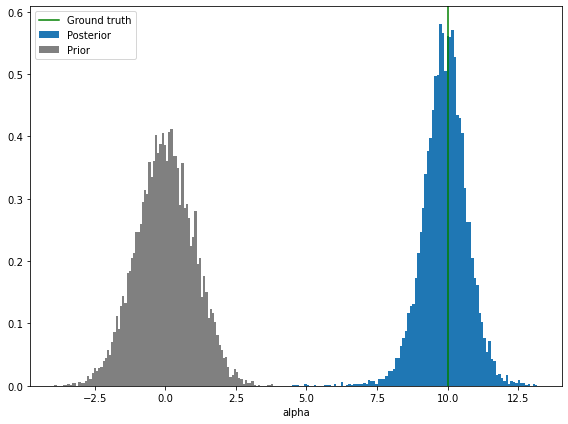

In [50]:
est_alpha = fit.extract()['alpha']

prior_hist_alpha = stats.norm.rvs(loc=0., scale=1., size=10000)

fig, ax = plt.subplots(1, 1,  tight_layout=True, figsize=(8,6))

ax.hist(est_alpha, density=True, bins=100, label='Posterior')
ax.hist(prior_hist_alpha, density=True, bins=100, color='gray', label='Prior')
ax.axvline(alpha, color='green', label='Ground truth')
ax.set_xlabel('alpha')
ax.legend()

With much heavier tails, the Cauchy prior allows the posterior to leak past the chosen scale and concentrate around the true value. Not only does the weaker regularization allow the posterior to concentrate around the true value, the tension between the prior and the likelihood becomes much easier to identify both visually and quantitatively. Careful analysis is still recommended, but less critical.

## Discussion

When building sophisticated models, principled priors that quantify principled prior information are critical to ensuring reasonable inferences. Weakly informative priors are particularly well-suited to this task, identifying natural scales in the problem to regularize the information extracted from the likelihood. The exact shape of those priors, however, has important practical consequences.

Lighter tailed priors, such as a Gaussian distribution, induce strong regularization towards the given scales. If the scales are consistent with the measurements then this regularization yields well-behaved posteriors that facilitate statistical computation. If the scales are poorly-chosen, however, then the regularization biases the resulting inferences as would any poor assumption in the model.

Heavier tailed priors induce weaker regularization which allows the posterior to assign significant probability mass above the chosen scale where the computation of the model may become slow or even unstable. On the other hand, the weaker regularization does not bias the model as strongly when the scales are inconsistent with the measurements.